# 프로젝트 제목

## 프로젝트 설명

## 프로젝트 루브릭

|학습 목표|평가 기준|
|---------|---------|
|한글 코퍼스를 가공하여 BERT pretrain용 데이터셋을 잘 생성하였다.|MLM, NSP task의 특징이 잘 반영된 pretrain용 데이터셋 생성과정이 체계적으로 진행되었다.|
|구현한 BERT 모델의 학습이 안정적으로 진행됨을 확인하였다.|학습진행 과정 중에 MLM, NSP loss의 안정적인 감소가 확인되었다.|
|1M짜리 mini BERT 모델의 제작과 학습이 정상적으로 진행되었다.|학습된 모델 및 학습과정의 시각화 내역이 제출되었다.|

# 사전 환경 세팅

## Colab 환경 세팅 함수 정의

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/AIFFEL/Deep_Dive/

Mounted at /content/drive
/content/drive/MyDrive/AIFFEL/Deep_Dive


In [2]:
!mkdir -p ./work/bert_pretrain
%cd ./work/bert_pretrain
!sudo apt-get update
!sudo apt-get install -y fonts-nanum fonts-noto-cjk
!fc-list | grep -i "nanum\|noto"
!pip install sentencepiece tqdm ipywidgets torchsummary torchinfo

/content/drive/MyDrive/AIFFEL/Deep_Dive/work/bert_pretrain
Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.6 kB]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,153 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRele

# 라이브러리 설치 및 호출

## 라이브러리 호출

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=fontpath, size=12)
plt.rcParams["font.family"] = fontprop.get_name()

print(f"설정된 폰트: {fontprop.get_name()}")

설정된 폰트: NanumBarunGothic


In [4]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

import os
import re
import math
import numpy as np
import pandas as pd
import random
import collections
import json
import shutil
import zipfile
import copy
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt

import sentencepiece as spm
from tqdm.notebook import tqdm

from torchinfo import summary

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)

# torch version
print(torch.__version__)

2.9.0+cu126


## 라이브러리 버전 확인

In [5]:
print(torch.__version__)
print(np.__version__)
print(pd.__version__)
print(matplotlib.__version__)
print(json.__version__)
print(re.__version__)

2.9.0+cu126
2.0.2
2.2.2
3.10.0
2.0.9
2.2.1


# Tokenizer 준비

In [6]:
corpus_file = './data/kowiki.txt'
prefix = './data/ko_32000'
vocab_size = 32000
#spm.SentencePieceTrainer.train(f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7} --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD] --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3 --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]")

In [7]:
corpus_file = './data/kowiki.txt'
prefix = './data/ko_8000'
vocab_size = 8000
#spm.SentencePieceTrainer.train(f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7} --model_type=bpe --max_sentence_length=999999 --pad_id=0 --pad_piece=[PAD] --unk_id=1 --unk_piece=[UNK] --bos_id=2 --bos_piece=[BOS] --eos_id=3 --eos_piece=[EOS] --user_defined_symbols=[SEP],[CLS],[MASK]")

In [8]:
data_dir = 'data'

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{data_dir}/ko_8000.model")

True

In [9]:
#Q. 특수 token 7개를 제외한 나머지 token들을 출력해봅시다.
vocab_list = []
for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):
            vocab_list.append(vocab.id_to_piece(id))
print(vocab_list)

['▁1', '▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다', '었다', '▁지', '▁수', '▁19', '▁가', '▁시', '▁20', '▁기', '▁전', '▁아', '▁하', '▁있다', '▁다', '▁제', '했다', '하였', '▁일', '▁한', '▁중', '▁정', '▁주', '하는', '▁것', '▁자', '▁공', '▁인', '되었다', '▁경', '▁위', '▁유', '▁보', '하고', '▁3', '▁등', '▁부', '하였다', '▁조', '하여', '▁미', '▁동', '▁선', '▁나', '으며', '▁모', '▁연', '▁영', '▁의', '▁오', '▁마', '에는', '▁발', '▁소', '한다', '▁고', '▁개', '▁201', '▁구', '▁세', '▁도', '▁상', '▁비', '▁스', '▁국', '▁서', '▁후', '▁여', '▁200', '▁때', '▁4', '▁성', '▁해', '▁관', '▁있는', '▁신', '▁프', '▁대한', '부터', '▁5', '00', '▁방', '▁또', '지만', '▁(', '▁역', '되어', '▁않', '▁만', '▁"', '▁장', '▁바', '까지', '▁무', '▁남', '▁통', '▁현', '▁교', '▁같', '에게', '▁내', '학교', '▁문', '▁출', '▁거', '▁포', '▁결', '된다', '▁《', '적인', '이라', '▁6', '▁우', '적으로', '▁불', '▁원', '▁최', '▁진', '▁생', '▁작', '▁어', '▁당', '국의', '▁노', '▁강', '▁알', '▁반', '▁7', '▁8', '▁계', '▁따', '▁파', '▁분', '▁없', '▁받', '▁말', '면서', '들이', 'or', '되었', '▁사용', "▁'", '▁두', '▁실', '에서는', '▁10', '▁리', '들은', '▁명', '▁함', '▁단', '▁이후', '하기', '▁예', '년에', '),',

# 데이터 전처리(1) MASK 생성

In [10]:
# Q. 위 코드들을 참고하여 아래 함수를 완성시켜주세요.
def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할 (띄어쓰기)
    cand_idx = []
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    # random mask를 위해서 순서를 섞음 (shuffle)
    random.shuffle(cand_idx)
    mask_lms = []
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:
            break
        if len(mask_lms) + len(index_set) > mask_cnt:
            continue
        dice = random.random()
        for index in index_set:
            masked_token = None
            if dice < 0.8:
                masked_token = "[MASK]"
            elif dice < 0.9:
                masked_token = tokens[index]
            else:
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token

    # mask_lms 정렬 후 mask_idx, mask_label 추출 (sorted 사용)
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens, mask_idx, mask_label

# NSP pair 생성

In [11]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

In [12]:
# Q. 위 코드들을 참고하여 아래 함수를 완성시켜주세요.
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):

        current_chunk.append(doc[i])
        current_length += len(doc[i])
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

# 데이터셋 완성

In [13]:
corpus_file = 'data/kowiki.txt'

# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

3957761

In [14]:
# 최대 길이
n_test_seq = 64
# 최소 길이
min_seq = 8
# [CLS], tokens_a, [SEB], tokens_b, [SEP]
max_seq = n_test_seq - 3

In [15]:
# Q. 아래 주석에 따라 코드를 완성해주세요.
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # 생성되는 단어 목록이 unknown인 경우는 제거합니다.
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)
                doc = []

In [16]:
pretrain_json_path = './data/bert_pre_train.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [17]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break

    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int32)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int32)
            label_mlm = np.full(n_seq, dtype=np.int32, fill_value=-100)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [18]:
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128)

  0%|          | 0/918173 [00:00<?, ?it/s]

# BERT 모델 구현

In [19]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = (tokens == i_pad).float()
    mask = mask.unsqueeze(1)
    return mask

def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tokens.size(1)
    ahead_mask = 1 - torch.tril(torch.ones((n_seq, n_seq)))
    ahead_mask = ahead_mask.unsqueeze(0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = torch.maximum(ahead_mask, pad_mask)
    return mask


In [20]:
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))


In [21]:
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return torch.nn.init.trunc_normal_

def bias_initializer():
    """
    bias initializer 생성
    """
    return torch.zeros_


In [22]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [23]:
class SharedEmbedding(nn.Module):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name (PyTorch에서는 사용되지 않음)
        """
        super().__init__()

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
        self.shared_weights = nn.Parameter(torch.empty(self.n_vocab, self.d_model))
        nn.init.trunc_normal_(self.shared_weights, std=0.02)  # TensorFlow와 동일한 초기화 적용

    def forward(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")

    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        inputs = torch.clamp(inputs, max=self.shared_weights.size(0) - 1)

        return self.shared_weights[inputs.long()]

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch, n_seq, _ = inputs.shape
        inputs = inputs.view(-1, self.d_model)  # (bs * n_seq, d_model)
        outputs = torch.matmul(inputs, self.shared_weights.T)
        outputs = outputs.view(n_batch, n_seq, self.n_vocab)  # (bs, n_seq, n_vocab)
        return outputs

In [24]:
class PositionEmbedding(nn.Module):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name (PyTorch에서는 사용되지 않음)
        """
        super().__init__()

        self.embedding = nn.Embedding(config.n_seq, config.d_model)
        nn.init.trunc_normal_(self.embedding.weight, std=0.02)

    def forward(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = torch.cumsum(torch.ones_like(inputs), dim=1) - 1
        position = position.long()
        embed = self.embedding(position)
        return embed


In [25]:
class ScaleDotProductAttention(nn.Module):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name (PyTorch에서는 사용되지 않음)
        """
        super().__init__()

    def forward(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = torch.matmul(Q, K.transpose(-2, -1))
        scale = torch.sqrt(torch.tensor(K.shape[-1], dtype=torch.float32))
        attn_scale = attn_score / scale
        attn_scale = attn_scale - (attn_mask * 1e9)
        attn_prob = F.softmax(attn_scale, dim=-1)
        attn_out = torch.matmul(attn_prob, V)
        return attn_out


In [26]:
# Q. 주석과 코드를 참조하여 아래 클래스를 완성해주세요.
class MultiHeadAttention(nn.Module):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name (PyTorch에서는 사용되지 않음)
        """
        super().__init__()

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_K = nn.Linear(config.d_model, config.n_head * config.d_head)
        self.W_V = nn.Linear(config.d_model, config.n_head * config.d_head)
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention()
        # output dense layer
        self.W_O = nn.Linear(config.n_head * config.d_head, config.d_model)

    def forward(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        batch_size = Q.shape[0]

        # reshape Q, K, V, attn_mask
        Q_m = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)
        K_m = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)
        V_m = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1, 2)
        attn_mask_m = attn_mask.unsqueeze(1)

        # Scale Dot Product Attention 실행
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)
        # (batch_size, n_seq, n_head, d_head)로 변환 후, (batch_size, n_seq, d_model)로 reshape
        attn_out_m = attn_out.transpose(1, 2).contiguous()  # (batch_size, n_seq, n_head, d_head)
        attn_out = attn_out_m.view(batch_size, -1, self.n_head * self.d_head)  # (batch_size, n_seq, d_model)
        attn_out = self.W_O(attn_out)  # (batch_size, n_seq, d_model)

        return attn_out

In [27]:
class PositionWiseFeedForward(nn.Module):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name (PyTorch에서는 사용되지 않음)
        """
        super().__init__()

        self.W_1 = nn.Linear(config.d_model, config.d_ff)
        self.W_2 = nn.Linear(config.d_ff, config.d_model)

        self.gelu = nn.GELU()

    def forward(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.gelu(self.W_1(inputs)))
        return ff_val


In [28]:
class EncoderLayer(nn.Module):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name (PyTorch에서는 사용되지 않음)
        """
        super().__init__()

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out


In [29]:
class BERT(nn.Module):
    """
    BERT Class
    """
    def __init__(self, config):
        """
        생성자
        :param config: Config 객체
        """
        super(BERT, self).__init__()

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = nn.Embedding(2, config.d_model)  # Segment embedding layer
        self.norm = nn.LayerNorm(config.d_model, eps=config.layernorm_epsilon)

        self.encoder_layers = nn.ModuleList([EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)])

        self.dropout = nn.Dropout(config.dropout)

    def forward(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: 입력 token들
        :param segments: 입력 segment들
        :return logits_cls: CLS 토큰에 대한 예측
        :return logits_lm: Masked Language Modeling 예측
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)

        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:, 0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm

    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed


In [30]:
# Encoder Layer class 정의
class PooledOutput(nn.Module):
    def __init__(self, config, n_output, name="pooled_output"):
        super(PooledOutput, self).__init__()

        self.dense1 = nn.Linear(config.d_model, config.d_model)
        self.dense2 = nn.Linear(config.d_model, n_output, bias=False)

    def forward(self, inputs):
        """
        forward pass
        :param inputs: 모델의 출력 (예: logits_cls)
        :return: softmax된 결과
        """
        outputs = F.tanh(self.dense1(inputs))
        outputs = self.dense2(outputs)
        # outputs = F.softmax(outputs, dim=-1)
        return outputs


In [31]:
class PreTrainModel(nn.Module):
    def __init__(self, config):
        super(PreTrainModel, self).__init__()
        self.bert = BERT(config)
        self.pooled_output = PooledOutput(config, 2)

    def forward(self, enc_tokens, segments):
        enc_tokens = enc_tokens.long()
        segments = segments.long()

        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        logits_cls = self.pooled_output(logits_cls)
        # outputs_nsp = F.softmax(logits_cls, dim=-1)

        # outputs_mlm = F.softmax(logits_lm, dim=-1)
        return logits_cls, logits_lm

def build_model_pre_train(config):
    return PreTrainModel(config)


In [32]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = Config({
    "d_model": 64,                  # 128
    "n_head": 4,                    # 4
    "d_head": 64,                   # 64
    "dropout": 0.1,                 # 0.1
    "d_ff": 1024,                   # 1024
    "layernorm_epsilon": 0.001,     # 0.001
    "n_layer": 3,                   # 3
    "n_seq": 128,                   # 256
    "n_vocab": vocab.get_piece_size(),                # 5000
    "i_pad": 0                      # 0
})

class Vocab:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.pad_id = 0

vocab = Vocab(config.n_vocab)
config.n_vocab = vocab.vocab_size
config.i_pad = vocab.pad_id

In [33]:
n_seq = 100

# make test inputs
enc_tokens = torch.randint(0, config.n_vocab, (10, n_seq))
segments = torch.randint(0, 2, (10, n_seq))
labels_nsp = torch.randint(0, 2, (10,))
labels_mlm = torch.randint(0, config.n_vocab, (10, n_seq))

batch_size = 10
train_dataset = TensorDataset(enc_tokens, segments, labels_nsp, labels_mlm)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [34]:
# 모델 불러오기
model = build_model_pre_train(config)

loss_fn_nsp = nn.CrossEntropyLoss()
loss_fn_mlm = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

summary(model, [(10, config.n_seq), (10, config.n_seq)])

Layer (type:depth-idx)                                       Output Shape              Param #
PreTrainModel                                                [10, 2]                   --
├─BERT: 1-1                                                  [10, 64]                  --
│    └─SharedEmbedding: 2-1                                  [10, 128, 64]             512,448
│    └─PositionEmbedding: 2-2                                [10, 128, 64]             --
│    │    └─Embedding: 3-1                                   [10, 128, 64]             8,192
│    └─Embedding: 2-3                                        [10, 128, 64]             128
│    └─LayerNorm: 2-4                                        [10, 128, 64]             128
│    └─Dropout: 2-5                                          [10, 128, 64]             --
│    └─ModuleList: 2-6                                       --                        --
│    │    └─EncoderLayer: 3-2                                [10, 128, 64]           

# pretrain 진행

In [35]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = F.cross_entropy(y_pred.view(-1, y_pred.size(-1)), y_true.view(-1), reduction='none')
    # pad(0) 인 부분 mask
    mask = (y_true != 0).float()
    loss = loss * mask
    return loss.mean() * 20   # mlm을 더 잘 학습하도록 20배 증가 시킴


In [36]:
def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = torch.argmax(y_pred, dim=-1).float()
    matches = (y_true == y_pred_class).float()
    # pad(0) 인 부분 mask
    mask = (y_true != 0).float()
    matches *= mask
    # 정확도 계산
    accuracy = matches.sum() / mask.sum().clamp(min=1)
    return accuracy


In [37]:
class CosineSchedule:
    """
    CosineSchedule Class for learning rate scheduling
    """
    def __init__(self, optimizer=None, train_steps=4000, warmup_steps=500, max_lr=2.5e-4):
        """
        생성자
        :param optimizer: Optimizer (PyTorch optimizer)
        :param train_steps: 총 학습 step 수
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        self.optimizer = optimizer
        self.train_steps = train_steps
        self.warmup_steps = warmup_steps
        self.max_lr = max_lr
        self.step_num = 0

    def get_lr(self):
        """
        learning rate 계산
        :return: 계산된 learning rate
        """
        if self.step_num <= self.warmup_steps:
            lr = (self.step_num / self.warmup_steps) * self.max_lr
        else:
            progress = (self.step_num - self.warmup_steps) / max(1, self.train_steps - self.warmup_steps)
            lr = 0.5 * self.max_lr * (1 + math.cos(math.pi * progress))
        return lr

    def step(self):
        """
        Step 함수: 매 학습 step마다 호출하여 learning rate를 업데이트
        """
        self.step_num += 1
        return self.get_lr()


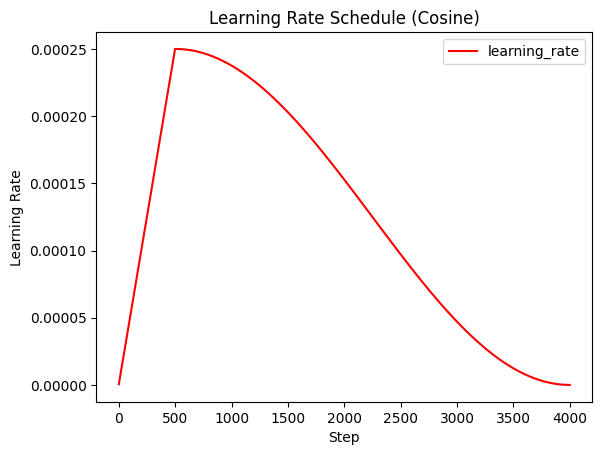

In [38]:
# compute lr
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule.step())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate Schedule (Cosine)')
plt.show()

In [39]:
epochs = 20
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate_scheduler = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_fn_nsp = nn.CrossEntropyLoss()
loss_fn_mlm = nn.CrossEntropyLoss()

train_steps: 286940


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU가 있으면 cuda 사용, 없으면 CPU

def to_tensor_from_memmap(x, device, dtype=torch.long):
    if isinstance(x, torch.Tensor):
        return x.to(device)
    # memmap, ndarray, list 전부 numpy array로 변환
    x = np.asarray(x)
    return torch.as_tensor(x, dtype=dtype, device=device)

pre_train_inputs  = [to_tensor_from_memmap(x, device) for x in pre_train_inputs]
pre_train_labels  = [to_tensor_from_memmap(x, device, dtype=torch.long) for x in pre_train_labels]

train_dataset = TensorDataset(pre_train_inputs[0], pre_train_inputs[1], pre_train_labels[0], pre_train_labels[1])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model.to(device)

PreTrainModel(
  (bert): BERT(
    (embedding): SharedEmbedding()
    (position): PositionEmbedding(
      (embedding): Embedding(128, 64)
    )
    (segment): Embedding(2, 64)
    (norm): LayerNorm((64,), eps=0.001, elementwise_affine=True)
    (encoder_layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attention): MultiHeadAttention(
          (W_Q): Linear(in_features=64, out_features=256, bias=True)
          (W_K): Linear(in_features=64, out_features=256, bias=True)
          (W_V): Linear(in_features=64, out_features=256, bias=True)
          (attention): ScaleDotProductAttention()
          (W_O): Linear(in_features=256, out_features=64, bias=True)
        )
        (norm1): LayerNorm((64,), eps=0.001, elementwise_affine=True)
        (ffn): PositionWiseFeedForward(
          (W_1): Linear(in_features=64, out_features=1024, bias=True)
          (W_2): Linear(in_features=1024, out_features=64, bias=True)
          (gelu): GELU(approximate='none')
        )
        

In [41]:
history = {
    'nsp_loss': [],
    'mlm_loss': [],
    'nsp_acc': [],
    'mlm_acc': []
    }

In [42]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_nsp_loss = 0
    total_mlm_loss = 0
    total_nsp_acc = 0
    total_mlm_acc = 0

    for batch in train_dataloader:
        enc_tokens_batch, segments_batch, labels_nsp_batch, labels_mlm_batch = batch
        optimizer.zero_grad()

        logits_nsp, logits_mlm = model(enc_tokens_batch, segments_batch)

        labels_nsp_batch = labels_nsp_batch.long()
        #labels_mlm_batch = labels_mlm_batch.clamp(0, config.n_vocab - 1).long()
        labels_mlm_batch = labels_mlm_batch.long()

        loss_nsp = loss_fn_nsp(logits_nsp, labels_nsp_batch)
        loss_mlm = loss_fn_mlm(logits_mlm.view(-1, logits_mlm.shape[-1]), labels_mlm_batch.view(-1))

        total_loss_batch = loss_nsp + loss_mlm
        total_loss += total_loss_batch.item()
        total_nsp_loss += loss_nsp.item()
        total_mlm_loss += loss_mlm.item()

        total_loss_batch.backward()
        optimizer.step()

        nsp_acc = (logits_nsp.argmax(dim=-1) == labels_nsp_batch).float().mean()
        mlm_acc = (logits_mlm.argmax(dim=-1) == labels_mlm_batch).float().mean()

        total_nsp_acc += nsp_acc.item()
        total_mlm_acc += mlm_acc.item()

    # 결과 저장
    history['nsp_loss'].append(total_nsp_loss / len(train_dataloader))
    history['mlm_loss'].append(total_mlm_loss / len(train_dataloader))
    history['nsp_acc'].append(total_nsp_acc / len(train_dataloader))
    history['mlm_acc'].append(total_mlm_acc / len(train_dataloader))

    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss / len(train_dataloader)}, "
          f"NSP Loss: {total_nsp_loss / len(train_dataloader)}, MLM Loss: {total_mlm_loss / len(train_dataloader)}, "
          f"NSP Accuracy: {total_nsp_acc / len(train_dataloader)}, MLM Accuracy: {total_mlm_acc / len(train_dataloader)}")

    # 모델 저장
    torch.save(model.state_dict(), f"./models/bert_pre_train_mod_config_epoch_{epoch+1}.pt")


Epoch 1/20 - Loss: 7.819698275976034, NSP Loss: 0.45229244821390024, MLM Loss: 7.367405827572066, NSP Accuracy: 0.715657394431049, MLM Accuracy: 0.003538180119271992
Epoch 2/20 - Loss: 7.402851168948316, NSP Loss: 0.39915638770605616, MLM Loss: 7.003694780647128, NSP Accuracy: 0.7529805432115771, MLM Accuracy: 0.005044521491021913
Epoch 3/20 - Loss: 6.984122607536313, NSP Loss: 0.3808362760720057, MLM Loss: 6.603286331070668, NSP Accuracy: 0.760751977464235, MLM Accuracy: 0.008151035098552563
Epoch 4/20 - Loss: 6.505955215546365, NSP Loss: 0.3754820471616907, MLM Loss: 6.130473168941378, NSP Accuracy: 0.7623381254738978, MLM Accuracy: 0.012302279206203269
Epoch 5/20 - Loss: 6.021304252463915, NSP Loss: 0.37161655743574773, MLM Loss: 5.649687694275164, NSP Accuracy: 0.7636214722870468, MLM Accuracy: 0.016165470729363317
Epoch 6/20 - Loss: 5.7545144594678685, NSP Loss: 0.3672693821632664, MLM Loss: 5.387245075523359, NSP Accuracy: 0.7657669556633624, MLM Accuracy: 0.018764891261962565
Ep

# 시각화

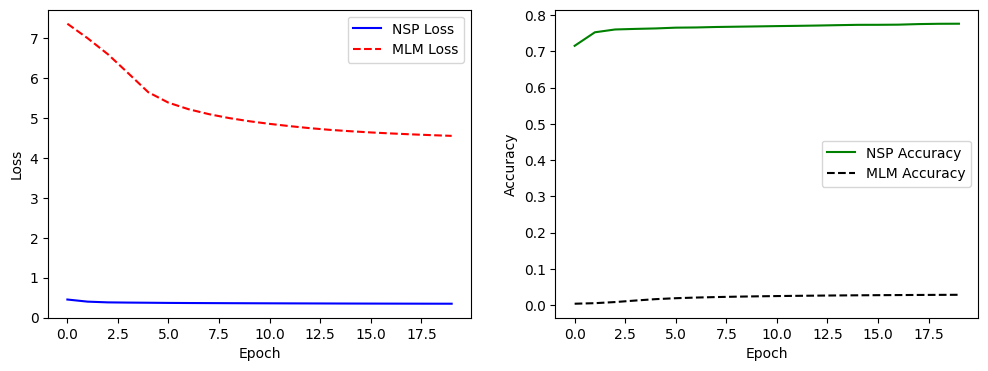

In [43]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['nsp_loss'], 'b-', label='NSP Loss')
plt.plot(history['mlm_loss'], 'r--', label='MLM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['nsp_acc'], 'g-', label='NSP Accuracy')
plt.plot(history['mlm_acc'], 'k--', label='MLM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

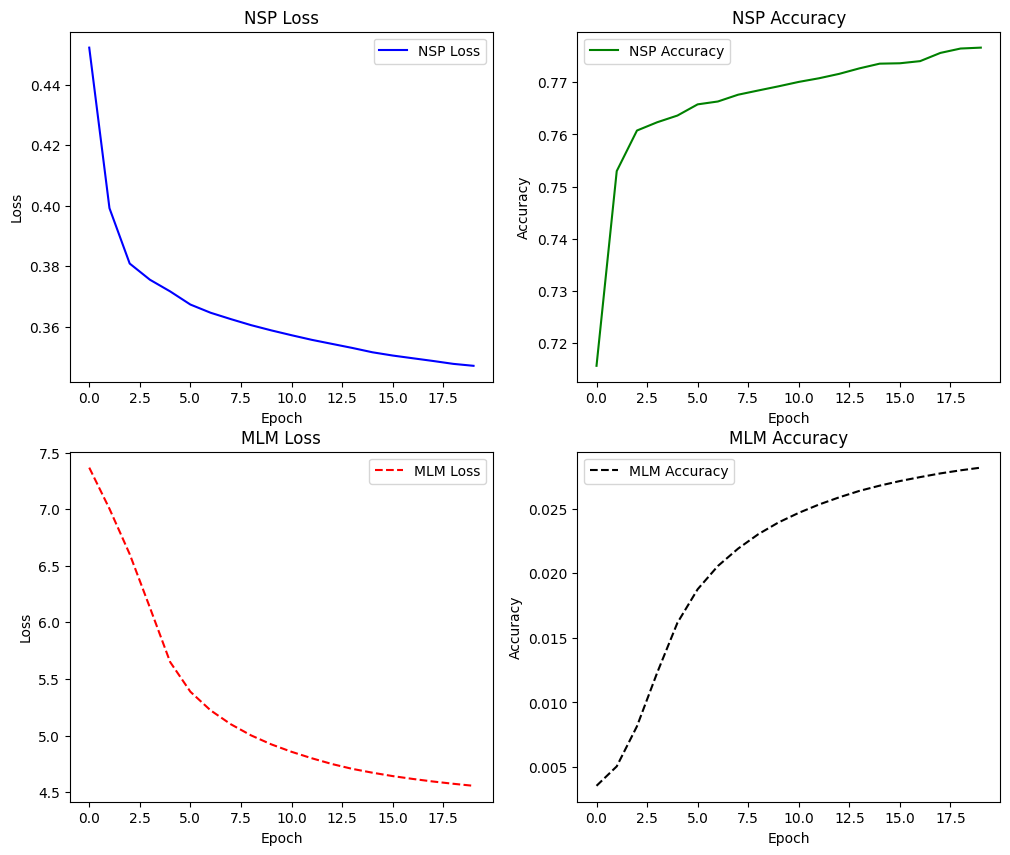

In [44]:
# training result
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.title("NSP Loss")
plt.plot(history['nsp_loss'], 'b-', label='NSP Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.title("NSP Accuracy")
plt.plot(history['nsp_acc'], 'g-', label='NSP Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.title("MLM Loss")
plt.plot(history['mlm_loss'], 'r--', label='MLM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.title("MLM Accuracy")
plt.plot(history['mlm_acc'], 'k--', label='MLM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# NSP, MLM 테스트 함수 구현

In [45]:
import sentencepiece as spm
import torch.nn.functional as F

# =====================================================================
# 1) SentencePiece vocab 다시 로드 (훈련에 사용한 ko_8000.model)
# =====================================================================
sp = spm.SentencePieceProcessor()
sp.load(f"{data_dir}/ko_8000.model")  # 위에서 쓰던 data_dir = 'data'

MASK_ID = sp.piece_to_id("[MASK]")
CLS_ID  = sp.piece_to_id("[CLS]")
SEP_ID  = sp.piece_to_id("[SEP]")
PAD_ID  = 0  # pretraining 때 pad_id=0 으로 사용

MAX_SEQ = config.n_seq  # 128
print("SentencePiece vocab size:", sp.get_piece_size())
print("CLS_ID, SEP_ID, MASK_ID:", CLS_ID, SEP_ID, MASK_ID)


SentencePiece vocab size: 8007
CLS_ID, SEP_ID, MASK_ID: 5 4 6


In [46]:
# =====================================================================
# 2) 텍스트를 BERT 입력 형식으로 변환하는 함수
#    - text_a: 첫 번째 문장
#    - text_b: 두 번째 문장 (NSP용, 없으면 None -> 한 문장만 사용)
# =====================================================================

def make_bert_inputs(sp, text_a, text_b=None, max_seq=MAX_SEQ, device=device):
    """
    text_a, text_b 를 받아서
    [CLS] tokens_a [SEP] tokens_b [SEP] 형태로 만들고
    (input_ids, segment_ids, tokens) 를 반환
    """
    # SentencePiece 토큰화
    tokens_a = sp.encode_as_pieces(text_a)
    tokens_b = sp.encode_as_pieces(text_b) if text_b is not None else []

    # [CLS], [SEP], [SEP] 3개를 뺀 최대 토큰 길이
    max_pair_len = max_seq - 3

    # 학습 때 쓰던 trim_tokens 재사용
    trim_tokens(tokens_a, tokens_b, max_pair_len)

    # 실제 토큰 시퀀스 구성
    tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
    segments = [0] * (len(tokens_a) + 2)

    # 두 번째 문장이 있을 때만 추가
    if len(tokens_b) > 0:
        tokens += tokens_b + ["[SEP]"]
        segments += [1] * (len(tokens_b) + 1)
    else:
        # 두 번째 문장이 없으면 뒤에 [SEP] 하나 더 붙여서 형태만 맞춰줌
        tokens += ["[SEP]"]
        segments += [1]

    # id로 변환
    input_ids = [sp.piece_to_id(p) for p in tokens]

    # 패딩/길이 맞추기
    if len(input_ids) > max_seq:
        input_ids = input_ids[:max_seq]
        segments = segments[:max_seq]
    else:
        pad_len = max_seq - len(input_ids)
        input_ids += [PAD_ID] * pad_len
        segments += [0] * pad_len

    # (1, seq_len) 형태 텐서로 변환
    input_ids = torch.tensor(input_ids, dtype=torch.long, device=device).unsqueeze(0)
    segments  = torch.tensor(segments,  dtype=torch.long, device=device).unsqueeze(0)

    return tokens, input_ids, segments


In [47]:
# =====================================================================
# 3) NSP(Next Sentence Prediction) 테스트 함수
# =====================================================================

def demo_nsp(model, sp, text_a, text_b):
    model.eval()
    with torch.no_grad():
        tokens, input_ids, segments = make_bert_inputs(sp, text_a, text_b, max_seq=MAX_SEQ, device=device)
        logits_nsp, _ = model(input_ids, segments)  # logits_nsp: (1, 2)

        probs = F.softmax(logits_nsp[0], dim=-1).cpu().numpy()
        not_next_prob = float(probs[0])
        is_next_prob  = float(probs[1])

    print("=== NSP Demo ===")
    print(f"[A] {text_a}")
    print(f"[B] {text_b}")
    print(f" -> P(not_next=0): {not_next_prob:.4f}")
    print(f" -> P(is_next=1):  {is_next_prob:.4f}")
    print()

In [48]:
# =====================================================================
# 4) MLM(Masked Language Model) 테스트 함수
# =====================================================================

def demo_mlm(model, sp, text, mask_pos=None, topk=5):
    """
    text: 원본 문장 (str)
    mask_pos: SentencePiece 토큰 시퀀스에서 몇 번째 토큰을 마스크할지 (None이면 가운데 토큰)
    topk: 상위 몇 개 토큰을 볼지
    """
    # 1) 원본 문장 토큰화
    pieces = sp.encode_as_pieces(text)
    if len(pieces) == 0:
        print("토큰이 없습니다. 문장을 다시 입력해 주세요.")
        return

    # 2) 마스크할 위치 결정
    if mask_pos is None:
        mask_pos = len(pieces) // 2  # 가운데 토큰을 기본으로 선택
    mask_pos = max(0, min(mask_pos, len(pieces) - 1))

    masked_pieces = pieces.copy()
    original_piece = masked_pieces[mask_pos]
    masked_pieces[mask_pos] = "[MASK]"

    # 3) BERT 입력 만들기 (두 번째 문장은 비워둠)
    tokens, input_ids, segments = make_bert_inputs(
        sp,
        "".join(masked_pieces),  # 단순하게 pieces를 다시 문자열로 합쳐서 사용
        text_b=None,
        max_seq=MAX_SEQ,
        device=device
    )

    # [CLS] + tokens_a + [SEP] 구조이므로,
    # tokens_a 안에서 mask_pos에 있던 토큰은 전체 시퀀스의 1 + mask_pos 위치에 대응
    # (마지막 [SEP] 하나가 더 붙어있지만 그 뒤에 있으므로 영향 없음)
    mask_index_in_full = 1 + mask_pos
    if mask_index_in_full >= MAX_SEQ:
        print("마스크 위치가 시퀀스 길이를 넘어갑니다. 더 짧은 문장을 사용해 주세요.")
        return

    model.eval()
    with torch.no_grad():
        _, logits_mlm = model(input_ids, segments)  # (1, seq_len, vocab)
        logits_at_mask = logits_mlm[0, mask_index_in_full]  # (vocab,)

        probs = F.softmax(logits_at_mask, dim=-1)
        topk_probs, topk_ids = torch.topk(probs, topk, dim=-1)

    print("=== MLM Demo ===")
    print(f"원본 문장   : {text}")
    print(f"토큰 시퀀스 : {pieces}")
    print(f"마스크 위치 : {mask_pos} 번째 토큰 '{original_piece}' -> [MASK]")
    print()
    print(f"[MASK] 위치 예측 Top-{topk}:")
    for i in range(topk):
        token_id = int(topk_ids[i].item())
        token_prob = float(topk_probs[i].item())
        token_piece = sp.id_to_piece(token_id)
        print(f"{i+1}. {token_piece:15s}  (prob={token_prob:.4f})")
    print()


# 결과

In [49]:
# 원하는 epoch의 가중치를 다시 불러오고 싶다면 (옵션)
# checkpoint_path = "./models/bert_pre_train_mod_config_epoch_20.pt"
# model.load_state_dict(torch.load(checkpoint_path, map_location=device))
# model.to(device)

example_a = "현대 수학은 일반적으로 엄밀한 논리에 근거하여 추상적 대상을 탐구하며, 자연 과학과 수학 자체의 필요에 의해 발전한 방법, 이론, 정리를 발견하고 체계화한다."
example_b = "수학은 그 발전 과정에 있어서 철학, 과학과 깊은 연관을 맺고 있으며, 엄밀한 논리와 특유의 추상성, 보편성이 다른 학문들과 구별되는 특징이다."

demo_nsp(model, sp, example_a, example_b)


=== NSP Demo ===
[A] 현대 수학은 일반적으로 엄밀한 논리에 근거하여 추상적 대상을 탐구하며, 자연 과학과 수학 자체의 필요에 의해 발전한 방법, 이론, 정리를 발견하고 체계화한다.
[B] 수학은 그 발전 과정에 있어서 철학, 과학과 깊은 연관을 맺고 있으며, 엄밀한 논리와 특유의 추상성, 보편성이 다른 학문들과 구별되는 특징이다.
 -> P(not_next=0): 0.3754
 -> P(is_next=1):  0.6246



In [50]:
example_text = "수학은 그 발전 과정에 있어서 철학, 과학과 깊은 연관을 맺고 있으며, 엄밀한 논리와 특유의 추상성, 보편성이 다른 학문들과 구별되는 특징이다."
demo_mlm(model, sp, example_text, mask_pos=None, topk=5)


=== MLM Demo ===
원본 문장   : 수학은 그 발전 과정에 있어서 철학, 과학과 깊은 연관을 맺고 있으며, 엄밀한 논리와 특유의 추상성, 보편성이 다른 학문들과 구별되는 특징이다.
토큰 시퀀스 : ['▁수학', '은', '▁그', '▁발전', '▁과정', '에', '▁있어서', '▁철', '학', ',', '▁과학', '과', '▁깊', '은', '▁연', '관을', '▁맺', '고', '▁있으며', ',', '▁엄', '밀', '한', '▁논', '리와', '▁특', '유', '의', '▁추', '상', '성', ',', '▁보', '편', '성이', '▁다른', '▁학', '문', '들과', '▁구', '별', '되는', '▁특징', '이다', '.']
마스크 위치 : 22 번째 토큰 '한' -> [MASK]

[MASK] 위치 예측 Top-5:
1. ▁등의              (prob=0.1275)
2. ▁및               (prob=0.1266)
3. ▁관련              (prob=0.0350)
4. ▁연구              (prob=0.0331)
5. ▁등               (prob=0.0288)



# 회고

- NSP는 0.45에서 0.34까지 loss가 하락했고 정확도 역시 0.78까지 상승하였다.
- 반면, MLM은 7.4에서 4.6까지 loss가 하락했고 정확도는 0.03에 그쳤다. 거의 학습이 안 된 것이라 볼 수 있다.
- 그 결과 실제 위키 문서에서 연속한 두 문장을 복사해와 테스트 하였더니 연속 여부에 대한 평가는 잘 나왔으나 한 문장에서 마스크를 적용한 것은 성능이 좋지 않았다.
- 학습용 데이터를 생성할 때 문제가 있었던 것 같은데 그 부분을 확인해 보지 못해서 아쉽다.
    - 중간에 clamp를 지우고 수정한 부분이 문제인 것 같아 추가적인 확인이 필요할 것 같다.